In [432]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
import skimage.measure    
import cv2
from scipy.stats import entropy

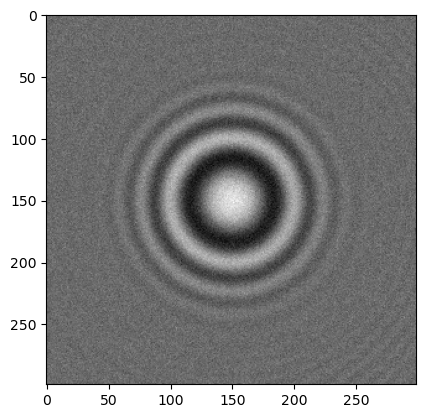

In [283]:
#first, extract hologram from .npy file
with np.load('dimer_data07.npz') as data:
    Y = data['arr_0']
    Y = Y[:299, :299]

#display hologram
fig, ax = plt.subplots()
ax.imshow(Y, cmap = 'gray')

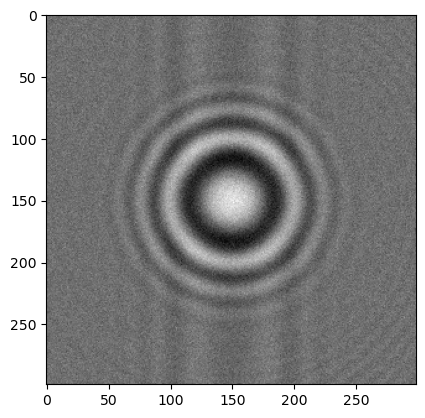

In [284]:
#pre-process by centering around 0, then normalizing to have sum=1
Y_ave = np.mean(Y, axis=0)
Y_centered = Y-Y_ave
Y_std = np.std(Y_centered)
Y_sum = np.sum(np.abs(Y_centered))
#Y_norm = Y_centered/Y_sum
Y_norm = Y_centered

#display hologram
fig, ax = plt.subplots()
ax.imshow(Y_norm, cmap = 'gray')

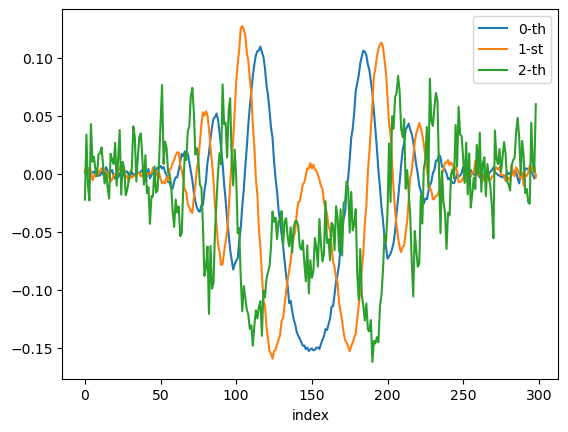

In [285]:
#do it two ways: using covariance matrix, using SVD.
Y_cov = Y_norm.T @ Y_norm
eigval, eigvec = linalg.eig(Y_cov)

#what does the eigenvector of the covariance matrix of an image mean? It should show the primary modes of variation
#plot the first few.
fig, ax = plt.subplots()
for i in range(3):
    suf = 'th'
    if i == 1:
        suf = 'st'
    ax.plot(eigvec[:,i], label = f'{i}-{suf}')
ax.legend()
ax.set_xlabel('index');

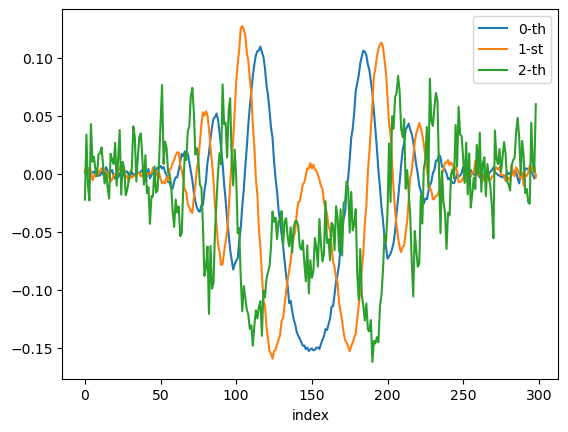

In [286]:
#before powering on forward, let's do the same thing, but using SVD decomposition
U, D, V_T = linalg.svd(Y_norm, full_matrices=False)
D = np.diag(D)
Y_cov_SVD = np.transpose(V_T) @ D @ np.transpose(U) @ U @ D @ V_T
eigval_SVD, eigvec_SVD = linalg.eig(Y_cov_SVD)

#plot
fig, ax = plt.subplots()
for i in range(3):
    suf = 'th'
    if i == 1:
        suf = 'st'
    ax.plot(eigvec_SVD[:,i], label = f'{i}-{suf}')
ax.legend()
ax.set_xlabel('index');

#### to compare the two methods, we can compute something known as the condition number, $\kappa_C$, that gives an idea of how numerically stable each method is. It is related to the singularity of a matrix. The more singular, the higher the condition number

In [287]:
norm_Y_cov = linalg.norm(Y_cov, 2)
norm_Y_cov_inv = linalg.norm(linalg.inv(Y_cov)) #change this to use linalg.solve
print(f'kappa_C = {norm_Y_cov*norm_Y_cov_inv}')

norm_Y_cov = linalg.norm(Y_cov_SVD, 2)
norm_Y_cov_inv = linalg.norm(linalg.inv(Y_cov_SVD)) #change this to use linalg.solve
print(f'kappa_C_SVD = {norm_Y_cov*norm_Y_cov_inv}')

#looks like the condition numbers are comparable, so we can proceed with either method.

kappa_C = 1.9458395884622336e+18
kappa_C_SVD = 4.964076097793987e+17


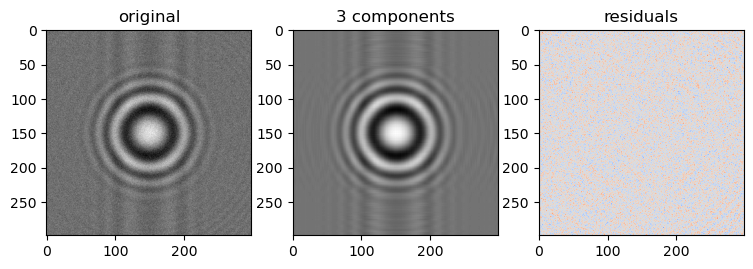

In [377]:
#it's time to compute the coefficients which will be used to reconstruct the hologram

def reconstruct(n, Y_norm):
    '''reconstruct hologram using PCA.
    n: number of components
    Y_norm: data'''

    #let's use SVD
    U, D, V_T = linalg.svd(Y_norm, full_matrices=False)
    D = np.diag(D)
    Y_cov = np.transpose(V_T) @ D @ np.transpose(U) @ U @ D @ V_T
    eigval, eigvec = linalg.eig(Y_cov)
    eigvec = eigvec[:, np.argsort(-eigval)]

    #reconstruct
    w = np.zeros((Y_norm.shape[0], n))
    eigvecs = np.zeros((Y_norm.shape[0], n))
    for i in range(n):
        c = Y_norm @ eigvec[:,i]
        w[:,i] = c
        eigvecs[:,i] = eigvec[:,i]
    Y_recons = w @ eigvecs.T

    #mean-squared error
    res = Y_recons - Y_norm
    mse = np.sum(res**2)/(res.shape[0]*res.shape[1])
    
    return Y_recons, res, mse

n = 3
Y_recons, res, mse = reconstruct(n, Y_norm)
fig, axs = plt.subplots(1, 3, figsize = (9,3))
axs[0].imshow(Y_norm, cmap = 'gray')
axs[1].imshow(Y_recons, cmap = 'gray')
axs[2].imshow(res, cmap = 'coolwarm')

axs[0].set_title('original')
axs[1].set_title(f'{n} components')
axs[2].set_title('residuals');

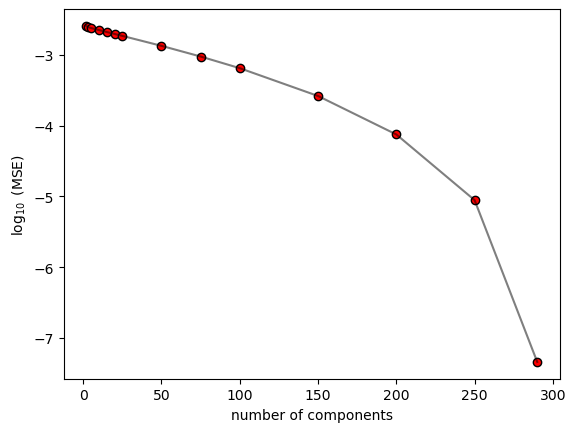

In [374]:
#track mse as a function of number of components
fig, ax = plt.subplots()
nlist = [2, 3, 5, 10, 15, 20, 25, 50, 75, 100, 150, 200, 250, 290]
err_list = []
for n in nlist:
    _, _, mse = reconstruct(n, Y_norm)
    err_list.append(mse)
ax.scatter(nlist, np.log10(err_list), marker = 'o', facecolor = 'r', edgecolor = 'k')
ax.plot(nlist, np.log10(err_list), 'k-', alpha = .5)
ax.set_xlabel('number of components')
ax.set_ylabel('$\log_{10}$ (MSE)');

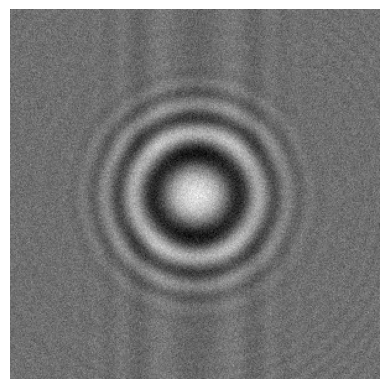

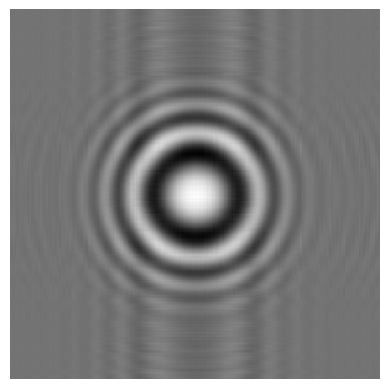

In [439]:
#we can save the images. Notice when you save how much smaller the filesize is for the reconstructed hologram!
plt.figure()
plt.imshow(Y_norm, cmap = 'gray')
plt.axis('off')
plt.savefig('Y_norm.png', bbox_inches = 'tight', pad_inches = 0)

Y_recons, res, mse = reconstruct(3, Y_norm)
plt.figure()
plt.imshow(Y_recons, cmap = 'gray')
plt.axis('off')
plt.savefig('Y_recons.png', bbox_inches = 'tight', pad_inches = 0)

In [440]:
#compute the entropy by first computing the probability distribution of the image in grayscale
def calc_entropy(img_path):
    img = cv2.imread(img_path)
    
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    h, _ = np.histogram(gray_image.ravel(), bins=128, range=(0, 128))
    
    prob_dist = h / np.sum(h)
    s = entropy(prob_dist, base=2)
    print(f"Image Entropy = {s} for {img_path[2:-4]}")

calc_entropy('./Y_norm.png')
calc_entropy('./Y_recons.png')

Image Entropy = 5.322043731792716 for Y_norm
Image Entropy = 4.629652155561792 for Y_recons
